<a href="https://colab.research.google.com/github/Adewuyipraise/Adewuyipraise/blob/main/Loan%20Default%20Prediction%20ML_LogisticsRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Iteration 0: Loss = 0.6931
Iteration 100: Loss = 0.4229
Iteration 200: Loss = 0.3207
Iteration 300: Loss = 0.2588
Iteration 400: Loss = 0.2163
Iteration 500: Loss = 0.1856
Iteration 600: Loss = 0.1625
Iteration 700: Loss = 0.1446
Iteration 800: Loss = 0.1304
Iteration 900: Loss = 0.1190
Iteration 1000: Loss = 0.1095
Iteration 1100: Loss = 0.1016
Iteration 1200: Loss = 0.0949
Iteration 1300: Loss = 0.0891
Iteration 1400: Loss = 0.0841
Iteration 1500: Loss = 0.0798
Iteration 1600: Loss = 0.0760
Iteration 1700: Loss = 0.0726
Iteration 1800: Loss = 0.0696
Iteration 1900: Loss = 0.0669

✅ Test Set Evaluation:
Accuracy:  0.9929
Precision: 0.9801
Recall:    1.0000

Confusion Matrix:
[[270   3]
 [  0 148]]


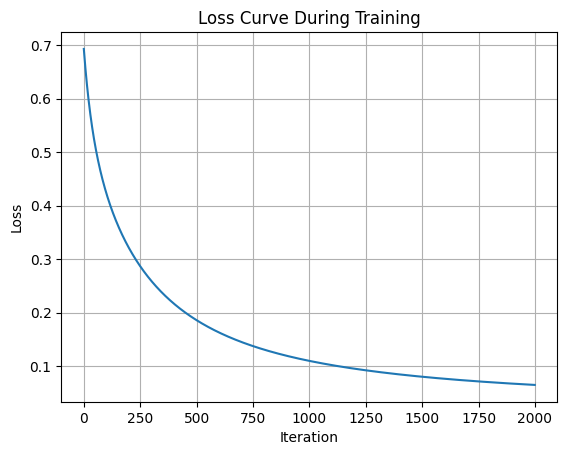

In [26]:
import pandas as pd
import numpy as np
from google.colab import files
uploaded = files.upload()

# Load the dataset
df = pd.read_csv('SBAcase.11.13.17.csv')

# Fill missing values
df['Bank'] = df['Bank'].fillna(df['Bank'].mode()[0])
df['BankState'] = df['BankState'].fillna(df['BankState'].mode()[0])
df['NewExist'] = df['NewExist'].fillna(df['NewExist'].mode()[0])
df['RevLineCr'] = df['RevLineCr'].fillna(df['RevLineCr'].mode()[0])
df['LowDoc'] = df['LowDoc'].fillna(df['LowDoc'].mode()[0])

# Fix DisbursementDate
df['DisbursementDate'] = pd.to_datetime(df['DisbursementDate'], errors='coerce')
df['DisbursementDate'] = df['DisbursementDate'].fillna(pd.to_datetime('1900-01-01'))
df['DisbursementDate'] = df['DisbursementDate'].apply(lambda x: x.timestamp())

# Fix ApprovalDate (Excel-style)
df['ApprovalDate'] = pd.to_datetime('1899-12-30') + pd.to_timedelta(df['ApprovalDate'], unit='D')
df['ApprovalDate'] = df['ApprovalDate'].apply(lambda x: x.timestamp())

# Optional: Drop 'xx' if exists
df = df.drop(columns=['xx'], errors='ignore')

# Handle ChgOffDate
df['HasChgOffDate'] = pd.to_datetime(df['ChgOffDate'], unit='D', errors='coerce').notnull().astype(int)
df = df.drop(columns=['ChgOffDate'], errors='ignore')

# Drop high-cardinality string columns
df = df.drop(columns=['Name', 'City', 'LoanNr_ChkDgt'], errors='ignore')

# Encode remaining categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Separate target
y = df_encoded['Default']
X = df_encoded.drop(columns=['Default'])

# Final check — remove any non-numeric columns
X = X.select_dtypes(include=['int64', 'float64'])

# Normalize
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert to NumPy arrays
X_np = X_scaled
y_np = y.values.reshape(-1, 1)






# Define logistic regression components
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def predict(X, w, b):
    z = np.dot(X, w) + b
    return sigmoid(z)

def compute_loss(y_true, y_pred):
    m = y_true.shape[0]
    loss = - (np.dot(y_true.T, np.log(y_pred + 1e-15)) +
              np.dot((1 - y_true).T, np.log(1 - y_pred + 1e-15))) / m
    return np.squeeze(loss)

def gradient_descent(X, y, w, b, learning_rate, iterations):
    m = X.shape[0]
    loss_history = []

    for i in range(iterations):
        y_pred = predict(X, w, b)
        loss = compute_loss(y, y_pred)
        loss_history.append(loss)

        dw = (1 / m) * np.dot(X.T, (y_pred - y))
        db = (1 / m) * np.sum(y_pred - y)

        w -= learning_rate * dw
        b -= learning_rate * db

        if i % 100 == 0:
            print(f"Iteration {i}: Loss = {loss:.4f}")

    return w, b, loss_history

def predict_classes(X, w, b, threshold=0.5):
    probs = predict(X, w, b)
    return (probs >= threshold).astype(int)








from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_np, y_np, test_size=0.2, random_state=42)

# Train
w = np.zeros((X_train.shape[1], 1))
b = 0
learning_rate = 0.01
iterations = 2000
w, b, loss_history = gradient_descent(X_train, y_train, w, b, learning_rate, iterations)

# Predict
y_pred_test = predict_classes(X_test, w, b)

# Evaluate
acc = accuracy_score(y_test, y_pred_test)
prec = precision_score(y_test, y_pred_test)
rec = recall_score(y_test, y_pred_test)
cm = confusion_matrix(y_test, y_pred_test)

print(f"\n✅ Test Set Evaluation:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print("\nConfusion Matrix:")
print(cm)


import matplotlib.pyplot as plt

plt.plot(loss_history)
plt.title("Loss Curve During Training")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid(True)
plt.show()
